In [1]:
!pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # for data manipulation
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController #Set Pandas options to display more columns
pd.options.display.max_columns=50
# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')
# Drop records where target RainTomorrow=NaN 
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())
# Create hande for vaniahloe that
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else 
                                                   '1.40-50'  if 40<x<=50 else '2.>50')
df['Humidity9amCat' ]=df[ 'Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
# Show a snaphsot of data
print(df)

             Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0      2008-12-01            Albury     13.4     22.9       0.6     5.303557   
1      2008-12-02            Albury      7.4     25.1       0.0     5.303557   
2      2008-12-03            Albury     12.9     25.7       0.0     5.303557   
3      2008-12-04            Albury      9.2     28.0       0.0     5.303557   
4      2008-12-05            Albury     17.5     32.3       1.0     5.303557   
...           ...               ...      ...      ...       ...          ...   
65292  2012-02-06  MelbourneAirport     10.3     24.0       2.0    10.600000   
65293  2012-02-07  MelbourneAirport     10.9     21.2       0.0     6.000000   
65294  2012-02-08  MelbourneAirport      8.9     21.7       0.0     5.600000   
65295  2012-02-09  MelbourneAirport      9.2     26.0       0.0     6.400000   
65296  2012-02-10  MelbourneAirport     15.3     25.8       0.0     6.200000   

        Sunshine WindGustDir  WindGustS

<ipython-input-2-804c8c5b8e55>:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [3]:
def probs(data, child, parent1=None, parent2=None):
  if parent1==None:
    prob=pd.crosstab(data[child],'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
  elif parent1!=None:
    if parent2==None:
      prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd. crosstab([data[parent1], data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
  else: print("Error in Probability Frequency Calculations")
  return prob
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child= 'Humidity3pmCat', parent1='Humidity9amCat'))
W =BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

bbn= Bbn() \
  .add_node(H9am) \
  .add_node(H3pm) \
  .add_node(W) \
  .add_node(RT) \
  .add_edge(Edge(H9am,H3pm, EdgeType.DIRECTED)) \
  .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
  .add_edge(Edge(W,RT, EdgeType.DIRECTED))


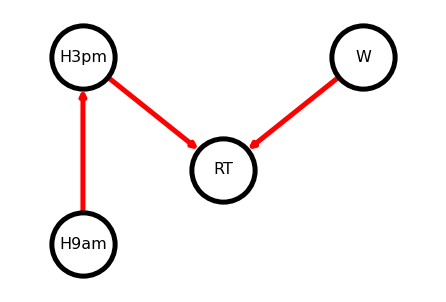

In [4]:
join_tree =InferenceController.apply(bbn)
pos={0: (-1,-2), 1: (-1, 0.5), 2: (1, 0.5), 3:(0,-1)}
options ={
"font_size": 16,
"node_size": 4000,
"node_color": "white",
"edgecolors": "black",
"edge_color": "red",
"linewidths": 5,
"width": 5,
}
n,d=bbn.to_nx_graph()
nx.draw(n, with_labels=True,labels=d, pos=pos, **options)

ax=plt.gca()
ax.margins (0.20)
plt.axis("off")
plt.show()